# Games Data Analysis

purpose of project:

identify patterns that determine whether a game succeeds or not using data from 2016. This will allow you to spot potential big winners and plan advertising campaigns.

In [123]:
import pandas as pd
import numpy as np
import plotly_express as px

from matplotlib import pyplot as plt 
from scipy.stats import pearsonr 


In [2]:
games = pd.read_csv('games.csv')


In [3]:

display(
    games.sample(5),
    games.dtypes,
    games.isnull().sum(),
)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
15286,Triple Crown Championship Snowboarding,Wii,2010.0,Sports,0.02,0.00,0.0,0.00,NaN,NaN,NaN
5591,Madden NFL 09,DS,2008.0,Sports,0.30,0.00,0.0,0.02,NaN,7.8,E
4536,Backyard Baseball,GBA,2002.0,Sports,0.31,0.11,0.0,0.01,NaN,NaN,NaN
3480,NHL 06,PS2,2005.0,Sports,0.48,0.02,0.0,0.08,78.0,8.5,E10+
4985,FIFA 14,Wii,2013.0,Sports,0.00,0.36,0.0,0.02,NaN,4.3,E


Name                object
Platform            object
Year_of_Release    float64
Genre               object
NA_sales           float64
EU_sales           float64
JP_sales           float64
Other_sales        float64
Critic_Score       float64
User_Score          object
Rating              object
dtype: object

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

# Cleaning Data

In [4]:
# converting the column names to lowercase
games.columns = [x.lower() for x in games.columns ]

dealing with incorrect data types 

incorrect data types:
* user_score: str > float 
* year_of_release: float > int


In [5]:
# some missing users scores are denoted to tbd instead of NaN 
games.replace('tbd', np.nan, inplace= True)

# change type to float 
games['user_score'] = games['user_score'].astype(float)

# change type to int, theres some nan values that we need to ignore in type conversion
games['year_of_release'] = games['year_of_release'].astype(int, errors= 'ignore')

Dealing with missing values

_Columns with nan values_:
* name
* year_of_release
* critic_store
* user_score
* rating

In [6]:
# drop all missing names
games = games.dropna(subset= ['name'])

# replace missing game years with 0 so they can be identified as outliers during analysis 
games['year_of_release'] = games['year_of_release'].fillna(0)
games['year_of_release'] = games['year_of_release'].astype(int)

In [7]:
# Some games are listed across multiple platforms 
# we can assume that the critic score will be the same for different platforms for the same game

def platform_critic(group):
    return group.fillna(group.mean())

# apply transformation 
games['critic_score'] = games.groupby('name')['critic_score'].transform(platform_critic)

# no way to reliably fill the remaining missing values 
games['critic_score'].fillna(-1, inplace = True)

In [8]:
# the same logic can be applied to the user scores amoung different platform releases 

def platform_user(group):
    return group.fillna(group.mean())

games['user_score'] = games.groupby('name')['user_score'].transform(platform_user)

games['user_score'].fillna(-1, inplace = True)

In [9]:
# all different types of age rating 
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [10]:
# in order to fill the missing ratings witha logical system, group platforms and genres and replace missing values witht the average rating of each pairing 

# map letter ratings to numerical representation
mappings = {
    'E': 0,
    'M': 13,
    'E10+': 17,
    'T' : 20,
    'K-A' : 25,
    'AO' : 30,
    'EC' : 45,
    'RP' : 50
}

games['rating'] = games['rating'].replace(mappings)

# function for deriving the mode of each pairing 
def get_first_mode(series):
    modes = series.mode()
    # series.mode() produces series objects, index just the letter rating else return none
    if len(modes) > 0:              
        return modes.iloc[0]
    else:
        return None
    
# apply get_first_mode function to grouped series object
mode_ratings = games.groupby(['platform', 'genre'])['rating'].transform(get_first_mode)

# fill missing values with new mode (numerical) representations 
games['rating'] = games['rating'].fillna(mode_ratings)

# inverse mapping to get just the letter ratings 
invmap = {v: k for k, v in mappings.items()}
games['rating'] = games['rating'].map(invmap)

# fill remaining missing (those without info pairs) with unknown 
games['rating'].fillna('unknown', inplace= True)

In [11]:
# final check 
games.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Adding new columns

* total sales column

In [12]:
# set location to after other sales figures and values to all columns added up 
loc = 8
total_sales = games['eu_sales'] + games['na_sales'] + games['jp_sales'] + games['other_sales']
games.insert(loc = loc, column= 'total_sales', value= total_sales)



<u>Cleaning Data Conclusions: </u> 

    _changing data type_
    
initially strings in user scores needed to be changed to float values, this allows us to do numeric caluculations and compare with other numeric columns such as critic score and sales. the years were changed to int values for aestetic purposes as we commonly only see years with just the year and nothing is gained from having decimal years.


    _filling missing values_ 

where possible missing values were filled with averages or placeholder values, names however were dropped as they were small in number and integral for decerning unique rows 

    _adding columns_

adding a total sales is a helpful as a visual aid and to general analysis 

# Analysing The Data 

* Look at how many games were released in different years. Is the data for every period significant? [1]

* Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data [2] 

* for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?[3]

* Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a model for 2017. [4]

* Work only with the data that you've decided is relevant. Disregard the data for previous years. [5]

* Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.
Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings. [6]

* Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions. [7]

Keeping your conclusions in mind, compare the sales of the same games on other platforms.
Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales? [8]





<u> Look at how many games were released in different years. Is the data for every period significant?:

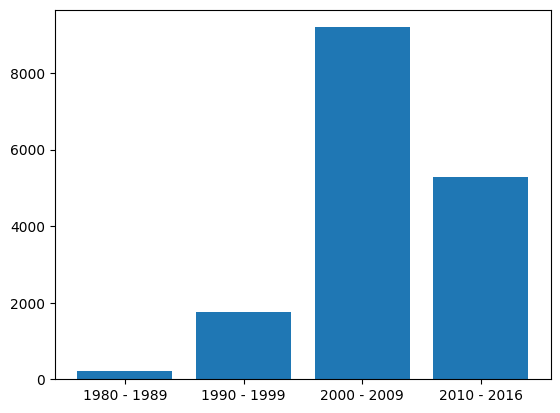

In [13]:
# count the number of titles in every single year individually 
total_years = games.groupby('year_of_release')['name'].count().reset_index()

# get the number of titles in each decade 
first_10 = total_years.query('0 < year_of_release < 1990')['name'].sum()
second_10 = total_years.query('1990 <= year_of_release < 2000')['name'].sum()
third_10 = total_years.query('2000 <= year_of_release < 2010')['name'].sum()
fourth_10 = total_years.query('2010 <= year_of_release < 2017')['name'].sum()

# apply the the values to a new dataframe 
grouped_years = {'1980 - 1989': first_10, 
                 '1990 - 1999': second_10,
                 '2000 - 2009': third_10,
                 '2010 - 2016': fourth_10}
# display data
sale_years = plt.bar(grouped_years.keys(), grouped_years.values())

plt.show()

Theres more titles from the naughties than any other era, it's important to note that the decade 2010- 2016 is imcomplete and therefore its going to be lower however interpolating data from the previous two dacades shows that game production should increase.

data from 2000 onwards inclusive is likely to be the most relervant

In [70]:
upper_quatile_sales: float = games.groupby('platform')['total_sales'].sum().reset_index().query('total_sales > 1').describe()['total_sales'].iloc[[5]].iloc[0]

upper_quatile_platforms = games.groupby('platform')['total_sales'].sum().reset_index()

upper_quatile_platforms = upper_quatile_platforms[upper_quatile_platforms.total_sales > upper_quatile_sales]['platform'].unique()
upper_quatile_platforms = np.append(upper_quatile_platforms, 'XOne')
df_filtered = games[games['platform'].isin(upper_quatile_platforms)]
#df_filtered = df_filtered[df_filtered.total_sales > 2.5]

In [71]:
px.histogram(df_filtered,
             nbins = 30,
             x= 'total_sales',
             histnorm= 'percent',
             color= 'platform',
             barmode= 'overlay')

for each year. Find platforms that used to be popular but now have few sales. How long does it generally take for new platforms to appear and old ones to fade? [3]

In [72]:
# create dataframe excluding all '0'/ 'missing' years summing each year 
games_years = games[games.year_of_release > 0].groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
#filter unpopular platforms
games_years = games_years[games_years['platform'].isin(upper_quatile_platforms)]


In [73]:
# create function that determines at which point has a platform has "faded" i have defined this as as which point did the sales drop belowe 75%
def years_to_drop_below_threshold(df):
    result = {}

    # Iterate over each platform
    for platform in df['platform'].unique():
        platform_data = df[df['platform'] == platform]
        max_sales = platform_data['total_sales'].max()
        max_year = platform_data.loc[platform_data['total_sales'].idxmax()]['year_of_release']
        
        #filter data so it only includes data from after the max 
        platform_data = platform_data[platform_data['year_of_release'] > max_year]

        # Find the first year when sales drop below 75% of the max sales
        threshold_sales = 0.75 * max_sales
        years_below_threshold = platform_data[platform_data['total_sales'] < threshold_sales]
        
        first_year_below_threshold = years_below_threshold.iloc[0]['year_of_release']
        years_to_threshold = first_year_below_threshold - max_year
        result[platform] = years_to_threshold
        

    return result

# Call the function and print the results
result_years_to_threshold = years_to_drop_below_threshold(games_years)
print("Number of years for sales to drop below 75% of its max sales after reaching max sales:")
for platform, years in result_years_to_threshold.items():
    print(f"{platform}: {years} years")

#Print averages
def Average(lst): 
    return sum(lst) / len(lst) 
average = round(Average(list(result_years_to_threshold.values())))
print(f"Average number of years a platform takes to fade: {average}")

Number of years for sales to drop below 75% of its max sales after reaching max sales:
3DS: 3 years
DS: 3 years
GB: 1 years
GBA: 1 years
PC: 1 years
PS: 2 years
PS2: 2 years
PS3: 1 years
PS4: 1 years
PSP: 2 years
Wii: 1 years
X360: 2 years
XB: 2 years
XOne: 1 years
Average number of years a platform takes to fade: 2


generally, after reaching its peak number of sales a platform will be able to retain a decent level of sales for 2 years, this gap allows other platforms to emerage and become established. This does not take into account how long it took for the platform to reach their max or how consistent they were around the max (if they had good sales for ages vs low sales and then a high spike)

Determine what period you should take data for. To do so, look at your answers to the previous questions. The data should allow you to build a model for 2017.

Work only with the data that you've decided is relevant. Disregard the data for previous years.


from the first question we determined post 2000 data is the most significant and only those from "popular platforms" what we defined earlier

In [75]:
# filter out only useful data (in supplimentary info it says 2016 data is impcomplete)
new_games = games[games.year_of_release > 1999]
new_games = games[games.year_of_release < 2016]
new_games = new_games[new_games['platform'].isin(upper_quatile_platforms)]


Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.
Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.

In [76]:
new_games_grouped = new_games[new_games.year_of_release > 0].groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()


px.line(new_games_grouped,
        x = 'year_of_release',
        color = 'platform',
        y = 'total_sales')

based on visual data from this the most profitable platforms are PS4 XONE and 3DS, PS4 and XOne are the only ones currently growing 

In [96]:
# test of average sales across different platforms on the 

top_3_sales = new_games.groupby(['platform'])['total_sales'].mean().round(3).sort_values().iloc[-3:].to_dict()
print("Highest sales per game on average:")
for platform, average in top_3_sales.items():
    print(f"Average number of sales for {platform}: {average}")

Highest sales per game on average:
Average number of sales for XOne: 0.832
Average number of sales for PS4: 1.074
Average number of sales for GB: 2.607


Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

In [147]:
cols = ['user_score','critic_score','total_sales']
new_games_score = new_games[new_games[cols] > 0][cols].dropna()

new_games_score['user_score'] = new_games_score['user_score'] *10
new_games_score['average_score'] = (new_games_score['user_score'] + new_games_score['critic_score']) / 2

In [151]:
pearsonr(new_games_score['average_score'], new_games_score['total_sales'])

PearsonRResult(statistic=0.18631961291046223, pvalue=4.261290062888141e-58)

In [118]:
px.scatter(new_games_score)

In [140]:
critic_score = list( new_games_score['critic_score'])
user_score = list( new_games_score['user_score'])

correlation = []
for critic in critic_score:
    for user in user_score:
        correlation.append(critic / user)

In [141]:
display(correlation[0:5],
critic_score[0:5],
user_score[0:5])

[0.95, 0.9156626506024096, 0.95, 0.8941176470588236, 1.1515151515151516]

[76.0, 82.0, 80.0, 89.0, 58.0]

[80.0, 83.0, 80.0, 85.0, 66.0]

In [142]:
average_corr = Average(correlation)

print(f"The average correlation between critic score and user score is {average_corr: .4}")

The average correlation between critic score and user score is  1.056


the average correlation between critic and user score being 1.056 shows that the critic score and user score is highly correlated and the scores are more or less the same when accounted for the fact that they are graded on different scales (/10 vs /100). there is however a small positive skew towards critic score being a couple points higher